# aTools Investigation on Images Background adaptation for Auxtel 2024



- author Sylvie Dagoret-Campagne
- creation date 2024-05-04
- last update 2024-05-04

w_2024_16


- https://github.com/lsst-dm/analysis_tools_examples


Import statements that we will need later

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import lsst.analysis.tools
from lsst.analysis.tools.interfaces import AnalysisTool
from lsst.analysis.tools.actions.vector import CoaddPlotFlagSelector, SnSelector, StarSelector, LoadVector, ExtinctionCorrectedMagDiff
from lsst.analysis.tools.actions.scalar import MedianAction, MeanAction, SigmaMadAction
from lsst.analysis.tools.actions.plot import SkyPlot
from lsst.analysis.tools.atools import ShapeSizeFractionalDiff

import lsst.daf.butler as dafButler
from lsst.analysis.tools.interfaces._task import _StandinPlotInfo
%matplotlib widget

In [2]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [3]:
#dataId = {"skymap": "latiss_v1", "tract": 5615, "instrument": "LATISS"}
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

Let's make a new plot and metric tool, we'll base it on the example in the getting started guide.

In [4]:

tract_sel = 3864
patch_sel = 237 # or 236
band_sel = "g"
table_sel = "objectTable_tract"

# plotting range for visits
XLIM = (122.3,122.7)
YLIM = (-36.3,-36.05)

In [5]:

dataId = {"skymap": skymapName , "tract": tract, "instrument": instrument}

repo = '/sdf/group/rubin/repo/oga/'
Butler = dafButler.Butler(repo)
t = Butler.get(table_sel, dataId=dataId, collections=collection )

In [6]:
# Add the patch and band to the dataId, we didn't need them for the objectTable_tract because it covers all patches and bands
# However the coadds are stored by patch and band dimensions so we have to add them to the dataId
dataId["band"] = band_sel
dataId["patch"] = patch_sel

In [7]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

## Deep Coadd Background

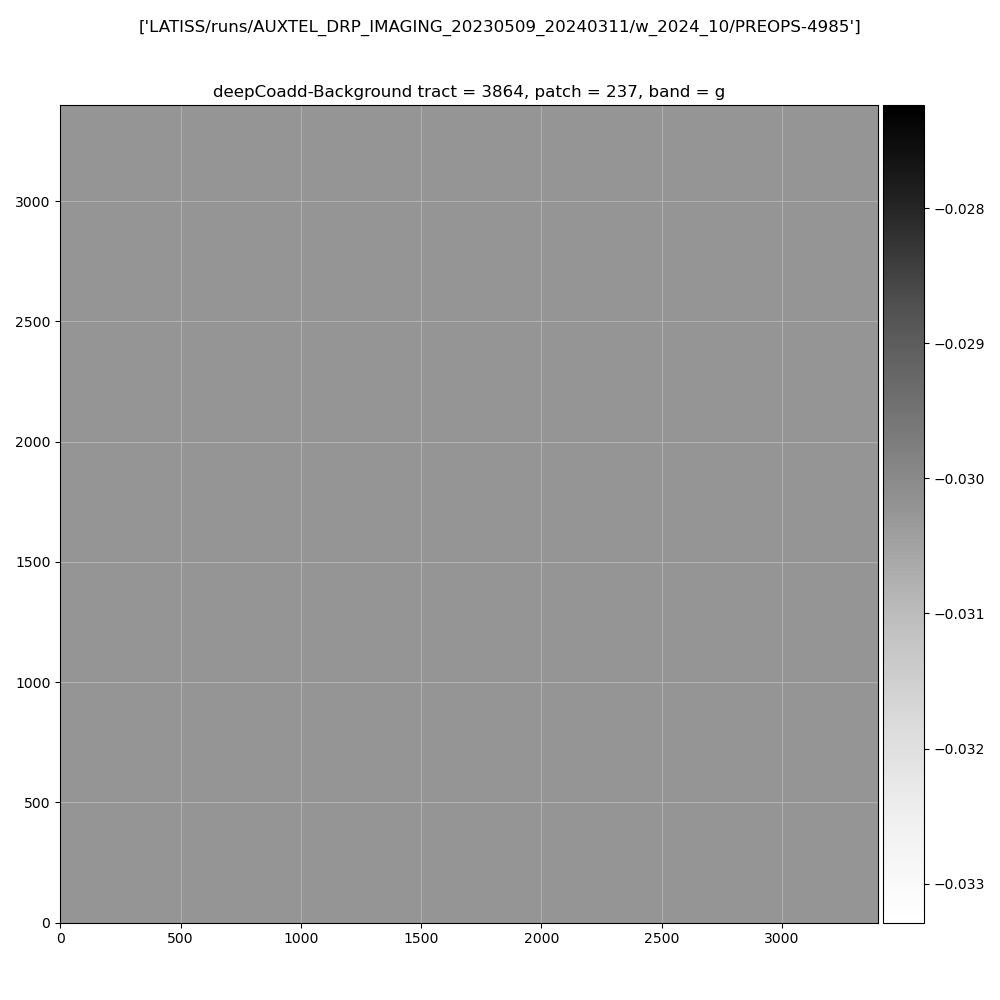

In [24]:
bg_coadd  = Butler.get("deepCoadd_calexp_background", dataId=dataId, collections=collections)
bg_coadd_image = bg_coadd.getImage()

#wcs = img.getWcs()
#bbox = img.getBBox()
#corners_ra, corners_dec = get_corners_radec(wcs, bbox)
#extent = [np.min(corners_ra),np.max(corners_ra),np.min(corners_dec),np.max(corners_dec)]

# Display the image with a suitable scaling
med = np.median(bg_coadd_image.array.flatten())
sigMad = 1.4826 * np.median(np.fabs(bg_coadd_image.array.flatten() - med))
vmin = med - 3 *sigMad
vmax = med + 3 *sigMad
fig,ax = plt.subplots(1,1,figsize=(10,10))
#im=ax.imshow(bg_coadd_image.array, origin="lower",vmin=vmin, vmax=vmax, cmap="Greys",extent=extent)
im=ax.imshow(bg_coadd_image.array, origin="lower",vmin=vmin, vmax=vmax, cmap="Greys",)
ax.set_aspect('equal')
ax.grid()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
title = f"deepCoadd-Background tract = {tract_sel}, patch = {patch_sel}, band = {band_sel}"
ax.set_title(title)
plt.colorbar(im, cax=cax)
plt.suptitle(collections)
plt.tight_layout()
plt.show()

In [27]:
sigMad

0.0

In [26]:
bg_coadd_image.array.flatten()

array([-0.03026303, -0.03026303, -0.03026303, ..., -0.03026303,
       -0.03026303, -0.03026303], dtype=float32)

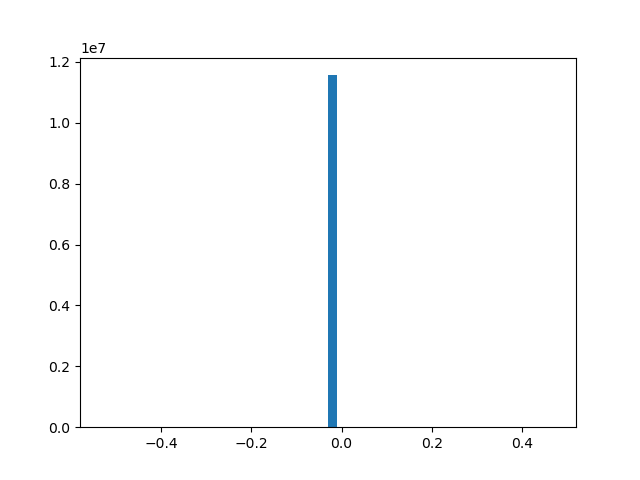

In [25]:
fig,ax = plt.subplots(1,1)
ax.hist(bg_coadd_image.array.flatten(),bins=50,range=(vmin,vmax))
plt.show()

## Deep Coadd Calexp

In [9]:
img = Butler.get("deepCoadd_calexp_background", dataId=dataId, collections=collections)
# Display the image with a suitable scaling
med = np.median(img.image.array.flatten())
sigMad = 1.4826 * np.median(np.fabs(img.image.array.flatten() - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad
fig,ax = plt.subplots(1,1,figsize=(10,10))
im=ax.imshow(img.image.array,origin="lower" ,vmin=vmin, vmax=vmax, cmap="Greys",extent=extent)
ax.set_aspect('equal')
ax.grid()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
title = f"deepCoadd_calexp tract = {tract_sel}, patch = {patch_sel}, band = {band_sel}"
ax.set_title(title)
plt.colorbar(im, cax=cax)
plt.suptitle(collections)
plt.tight_layout()
plt.show()

AttributeError: 'BackgroundList' object has no attribute 'image'

In [ ]:
assert False

In [ ]:
def catOutline(ras, decs):
    """A utility function to help draw outlines of points of ra and dec
    
    Parameters
    ----------
    ras : iterable
        The R.A. of the points
    decs : iterable
        The declination of the points
        
    Returns
    -------
    xMids : np.array
        The midpoints of the bins on the x axis
    yMids : np.array
        The midpoints of the bins on the y axis
    im : np.array
        A 2D array of the number of points in each bin
    """
    
    xWalls = np.linspace(np.min(ras) - 0.1, np.max(ras) + 0.1, 101)
    yWalls = np.linspace(np.min(decs) - 0.1, np.max(decs) + 0.1, 101)
    
    im, xBins, yBins = np.histogram2d(ras, decs, bins=(xWalls, yWalls))
    xMids = 0.5*(xBins[:-1] + xBins[1:])
    yMids = 0.5*(yBins[:-1] + yBins[1:])
    im[im > 0] = 1
    
    return xMids, yMids, im
    

To look at the visits that went into our object table we need to first find the data that went into it. The coadds are made from the visit level calexps so we will have a look at the calexps that are available in the butler. This gives us a list of visits. Once we have the visits we can read in the tables for each visit and then use those to plot the overlaps.


In [ ]:
print("Numbers of inputCount visits:", set(list(t[f"{band_sel}_inputCount"])))

# Get the visit numbers that went into the coadds, we don't actually need to read in the calexps but we want to
# get the visit numbers from their dataIds

registry = Butler.registry
refs = registry.queryDatasets("calexp", collections=collections)
visits = []
for ref in refs:
    if ref.dataId["band"] == band_sel:
        visits.append(ref.dataId["visit"])

visits = list(set(visits))
print("Total number of visits:", len(visits))


cmap = plt.cm.get_cmap('jet', len(visits))
colours = [matplotlib.colors.to_hex(cmap(i)) for i in range(len(visits))]

# Plot the visit outlines so we can look at the overlaps 
#colours = ["k", "b", "r", "g", "y", "C0", "C1", "C2"]
for (i, visit) in enumerate(visits):
    dataId["visit"] = visit
    try:
        visitTable = Butler.get("sourceTable_visit", dataId=dataId, collections=collections)
        xMids, yMids, im = catOutline(visitTable["coord_ra"], visitTable["coord_dec"])
        plt.contour(xMids, yMids, im.T, 1, colors=[colours[i]])
  
    except Exception as inst:
        #print(type(inst))    # the exception type
        #print(inst.args)     # arguments stored in .args
        #print(inst)          # __str__ allows args to be printed directly,
        pass

      
plt.gca().invert_xaxis()
plt.xlabel("R.A. / Degrees")
plt.ylabel("Dec. / Degrees")
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.grid()
plt.show()



The data still doesn't cover all the area that the visits covered, let's look at why.
We'll plot the patch outlines over the input visits, we know that only four patches are in the final catalogue.

In [ ]:
# Take all the ras and decs from the visit catalogues
# Is this the most efficent way to do this, probably not

rasAll = []
decsAll = []

for visit in visits:
    try:
        dataId["visit"] = visit
        visitTable = Butler.get("sourceTable_visit", dataId=dataId, collections=collections)
        rasAll += list(visitTable["coord_ra"])
        decsAll += list(visitTable["coord_dec"])
    except Exception as inst:
        #print(type(inst))    # the exception type
        #print(inst.args)     # arguments stored in .args
        #print(inst)          # __str__ allows args to be printed directly,
        pass
    
xMids, yMids, im = catOutline(rasAll, decsAll)
plt.contour(xMids, yMids, im.T, 1, colors=["k"])
    


plt.gca().invert_xaxis()
plt.xlabel("R.A. / Degrees")
plt.ylabel("Dec. / Degrees")
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.show()
